<a href="https://colab.research.google.com/github/Bhavya05shah/OCR-Digitalisation/blob/main/processing_health_record.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade google-cloud-vision

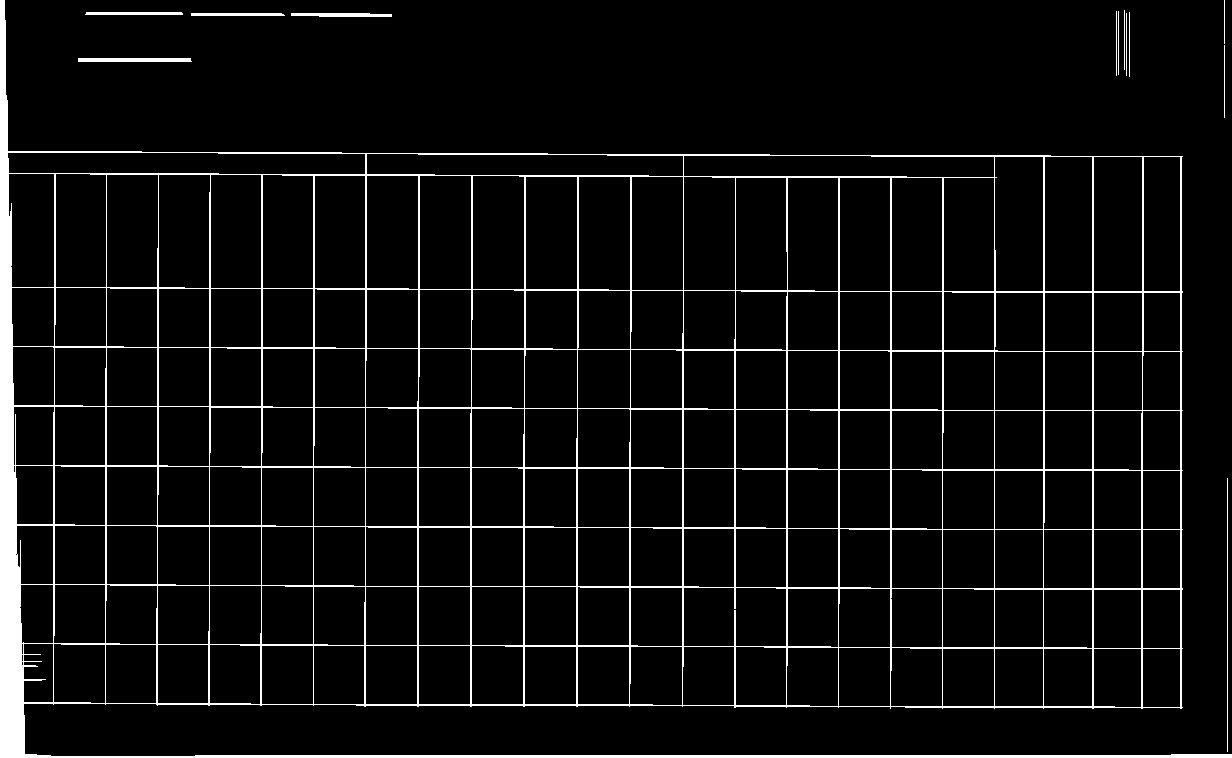

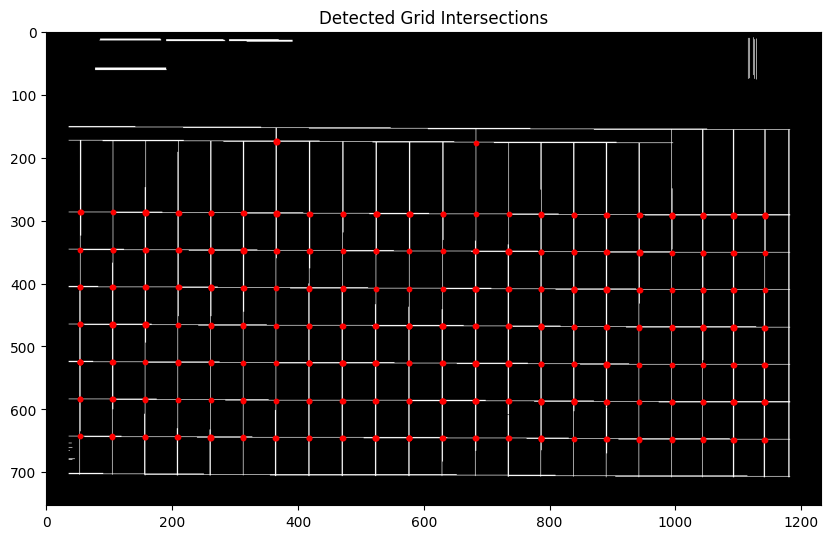

In [1]:
import cv2
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/content/siddhi-433908-47218de28261.json'
# from google.cloud import vision
# from google.cloud.vision_v1 import types

# Make sure 'OCRexp2.png' is in the correct directory or provide the full path.
image = cv2.imread('OCRexp2.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# # The client
# client = vision.ImageAnnotatorClient()

# # Loading the image in our notebook
# with open('/content/OCRexp2.png', 'rb') as image_file:
#     content = image_file.read()
#     image = vision.Image(content=content)

# # Perform text detection
# response = client.text_detection(image=image)
# texts = response.text_annotations
# for text in texts:
#     print(text.description)

def grid_detection(image_grayscale):
  _, binary = cv2.threshold(image_grayscale, 225, 275, cv2.THRESH_BINARY_INV)
  horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (70, 1))
  horizontal_lines = cv2.morphologyEx(binary, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
  vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 60))
  vertical_lines = cv2.morphologyEx(binary, cv2.MORPH_OPEN, vertical_kernel, iterations=1)
  grid = cv2.add(horizontal_lines, vertical_lines)
  (alpha,beta)=grid.shape
  #x_limit here suggests the number of grid rows
  #and 130 suggests the height of each grid row
  x_limit=11
  if alpha/130 >= 15:
    x_limit=15
  elif alpha/130 <= 5:
    x_limit=5
  elif 5<alpha/130 and alpha/130<10:
    if alpha%130<0.5:
      x_limit=alpha/130
    elif alpha%130>=0.5:
      x_limit=1+(alpha/130)
  cv2_imshow(grid)
  return grid, x_limit

def basic_noise_cleaner(grid):
    (alpha,beta)=grid.shape
    gamma=beta*(2/69)
    gamma=int(math.ceil(gamma))
    grid[:,:(gamma)]=0
    grid[:,beta-gamma:]=0
    grid=grid[:alpha-5, :]
    return grid

def plot_intersections(new_grid):
  intersections=[]
  alpha,beta=new_grid.shape
  for i in range(0,alpha-1):
    for j in range(0,beta-1):
      k=0
      while k<min(10,beta-j,alpha-i):
        if new_grid[i][j] == 255 and new_grid[i-k][j] == 255 and new_grid[i+k][j] == 255 and new_grid[i][j+k] == 255 and new_grid[i][j-k] == 255:
          pass
        else:
          break
        k+=1
        if k==min(10,beta-j,alpha-i):
          intersections.append((i,j))
        else:
          pass
  return intersections

# def place_sort(intersections,x_limit):
#   i = 0
#   while i < len(intersections) - 1:
#     if i + 1 < len(intersections) and abs(intersections[i][0] - intersections[i + 1][0]) < x_limit:
#       start = i
#       while i + 1 < len(intersections) and abs(intersections[i][0] - intersections[i + 1][0]) < x_limit:
#         i += 1
#       intersections[start:i + 1] = sorted(intersections[start:i + 1], key=lambda p: p[1])
#     else:
#       i += 1
#   print(intersections)
#   return intersections

# def remove_duplicates_with_tolerance(intersections,x_limit):
#   i = 0
#   while i < len(intersections) - 1:
#     if i + 1 < len(intersections) and all(
#         abs(intersections[i][j] - intersections[i + 1][j]) <= x_limit
#         for j in range(2)
#     ):
#       del intersections[i + 1]
#     else:
#       i += 1
#   return intersections

# def remove_false_positives(interestions,intersections,x_limit):
#   firsts=[]
#   i=0
#   while i < len(interestions):
#     firsts.append(interestions[i][0])
#     i+=1

#   firsts.sort()
#   repeated_x = []
#   x_reference=firsts[0]
#   count = 0
#   i=0
#   while i<len(firsts):
#     if abs(firsts[i]-x_reference)<x_limit:
#       count+=1
#     else:
#       count=1
#       x_reference=firsts[i]
#     if count>=4:
#       repeated_x.append(firsts[i])
#       repeated_x.append(firsts[i-1])
#       repeated_x.append(firsts[i-2])
#       repeated_x.append(firsts[i-3])
#     i+=1
#   for point in interestions:
#     if point[0] in repeated_x:
#       intersections.append((point[0],point[1]))
#   return intersections

grid, x_limit = grid_detection(gray)
cleaned_grid = basic_noise_cleaner(grid)
intersections = plot_intersections(cleaned_grid)
# reorganized_intersections = place_sort(intersections,x_limit)
# final_intersections = remove_duplicates_with_tolerance(reorganized_intersections,x_limit)
# new_final_intersections = remove_false_positives(final_intersections,final_intersections,x_limit)

# Convert intersections list into separate lists of x and y coordinates
x_coords = [j for i, j in intersections]
y_coords = [i for i, j in intersections]

# Plotting the grid image
plt.figure(figsize=(10, 10))
plt.imshow(cleaned_grid, cmap='gray')

# Plotting the intersection points
plt.scatter(x_coords, y_coords, color='red', s=10)

# Display the plot
plt.title("Detected Grid Intersections")
plt.show()
